In [1]:
from projet_etu import *
from mltools import *
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE



In [2]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)


In [3]:
def get_usps(l,datax,datay):
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    return tmpx,tmpy

In [4]:
def show_usps(images, random_indices ,n_images = 10):

    fig, axs = plt.subplots(1, n_images, figsize=(16, 4))
    for i, index in enumerate(random_indices):
        axs[i].imshow(images[index].reshape((16, 16)), cmap='gray')
        axs[i].axis('off')
    plt.show()

In [5]:
def one_hot(y,nb_classes):
    """
    Permet de transformer un vecteur d'indices y de classes en one-hot
    """
    onehot = np.zeros((y.size, nb_classes))
    onehot[np.arange(y.size), y] = 1
    return onehot

In [6]:
def normalize(datax, testx):
    min_value = np.min(np.concatenate((datax,testx)))
    max_value = np.max(np.concatenate((datax,testx)))

    datax_norm = (datax - min_value) / (max_value - min_value)
    testx_norm = (testx - min_value) / (max_value - min_value)

    return datax_norm, testx_norm

In [7]:
def generate_data(classes):
    """
    classes : liste des classes
    """
    uspsdatatrain = "./data/USPS_train.txt"
    uspsdatatest = "./data/USPS_test.txt"
    
    alltrainx,alltrainy = load_usps(uspsdatatrain)
    alltestx,alltesty = load_usps(uspsdatatest)
    
    datax,datay = get_usps(classes,alltrainx,alltrainy)
    testx,testy = get_usps(classes,alltestx,alltesty)

    datax, testx = normalize(datax, testx)

    datay = one_hot(datay, len(classes))
    testy = one_hot(testy, len(classes))
  
    
    return datax, testx, datay, testy

In [8]:
def noisy_data(data, type, proportion):
    """
    Ajoute du bruit à un jeu de données.
    data : numpy array, les données à bruitées
    type : str, le type de bruit ('gaussian', 'salt_and_pepper', 'poisson')
    p : float, la proportion de pixels bruités
    
    Retourne les données bruitées
    """
    noisy_data = np.copy(data)
    if type == 'gaussian':
        # Ajouter du bruit gaussien
        mean = 0
        variance = 0.1
        sigma = variance ** 0.5
        for i in range(noisy_data.shape[0]):
            noisy_data[i] += proportion * np.random.normal(mean, sigma, noisy_data[i].shape)
            
    elif type == 'salt_and_pepper':
        # Ajouter du bruit de sel et poivre
        for i in range(noisy_data.shape[0]):
            mask = np.random.rand(*noisy_data[i].shape) < proportion
            noisy_data[i][mask] = 0 if random.random() < 0.5 else 1
            
    elif type == 'poisson':
        # Ajouter du bruit de poisson
        for i in range(noisy_data.shape[0]):
            noisy_data[i] += np.random.poisson(lam=0.1, size=noisy_data[i].shape)
            
    return noisy_data

In [9]:
def plot_loss(iter,liste_loss):
    """
    Trace le graphe de l'évolution de la fonction de coût en fonction des itérations de la descente de gradient.

    iter: Le nombre d'itérations de la descente de gradient.
    liste_loss: La liste des valeurs de la fonction de coût à chaque itération.
    """
    plt.figure()
    plt.plot(np.arange(iter),liste_loss)
    plt.title("Loss")
    plt.xlabel("Iterations")
    plt.ylabel("loss")
    plt.show()

In [10]:
def reconstruct(opt, testx, len_encodeur):
    res_forward = [ opt._net._modules[0].forward(testx) ]

    for j in range(1, len(opt._net._modules)):
        res_forward.append( opt._net._modules[j].forward( res_forward[-1] ) )

    encoded = res_forward[len_encodeur-1]
    decoded = res_forward[-1]
    return encoded, decoded

In [11]:
def predict(opt, testx):
    res_forward = [ opt._net._modules[0].forward(testx) ]

    for j in range(1, len(opt._net._modules)):
        res_forward.append( opt._net._modules[j].forward( res_forward[-1] ) )
    
    yhat = np.argmax(res_forward[-1], axis=1)

    onehot = np.zeros((yhat.size, len(np.unique(yhat))))
    onehot[ np.arange(yhat.size), yhat ] = 1
    yhat = onehot

    return yhat

# Test sur les données de chiffres manuscrits

## Visualisation des images erconstruites après une forte compression

In [12]:
# Création données et constantes : 
classes = [i for i in range(10)]
datax,testx, datay, testy = generate_data(classes)

input = datax.shape[1]
output = 10
iteration = 100
gradient_step = 1e-4
size_batch = 100

In [13]:
print(datax.shape)
print(datay.shape)

(7291, 256)
(7291, 10)


In [14]:
# Module linéaire et Loss
loss = BCE()
linear1 = Linear(input, 100)
linear2 = Linear(100, output)
linear3 = Linear(output, 100)
linear3._parameters = linear2._parameters.T
linear4 = Linear(100, input)
linear4._parameters = linear1._parameters.T
tanh = TanH()
sig = Sigmoide()

In [15]:
#AutoEncodeur
encodeur = [linear1,tanh,linear2,tanh]
decodeur = [linear3,tanh,linear4,sig]
autoEncodeur = AutoEncodeur(encodeur, decodeur)

In [16]:
opt = Optim(autoEncodeur.modules, loss, eps=gradient_step)

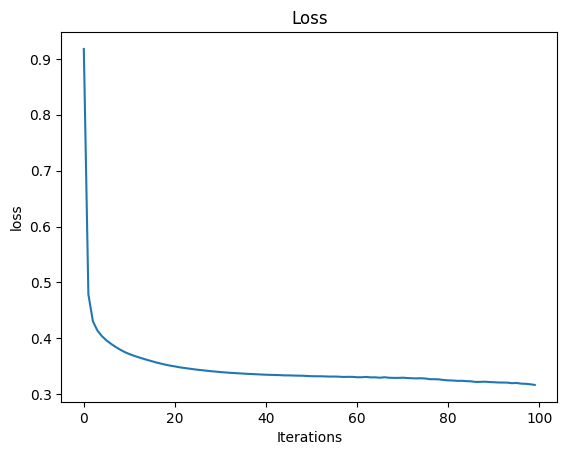

In [17]:
list_loss = opt.SGD(datax,datax,size_batch,iteration)
plot_loss(iteration,list_loss)

In [18]:
encoded, decoded = reconstruct(opt, testx, len(encodeur))

In [19]:
print(encoded.shape, decoded.shape)

(2007, 10) (2007, 256)


In [20]:
nb_indices = 10
random_indices = random.sample(range(len(decoded)),nb_indices)

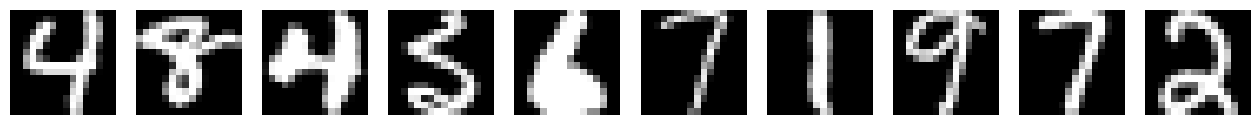

In [21]:
show_usps(testx, random_indices, nb_indices)

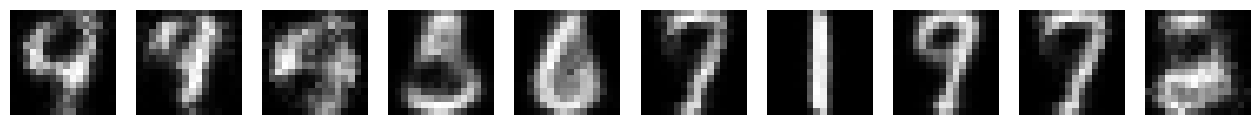

In [22]:
show_usps(decoded, random_indices, nb_indices)

## Accuracy des prédictions sur les images reconstruites

In [23]:
# Constante
input = datax.shape[1]
output = 10
iteration = 100
gradient_step = 1e-2
batchsize = 10

In [24]:
# Module linéaire et Loss
loss = CElogSMLoss()
linear1 = Linear(input, 256)
linear2 = Linear(256, 128)
linear3 = Linear(128, output)
tanh = TanH()

In [25]:
seq2 = Sequential([linear1,tanh,
                  linear2,tanh,
                  linear3])

In [26]:
opt2 = Optim(seq2, loss, eps=gradient_step)

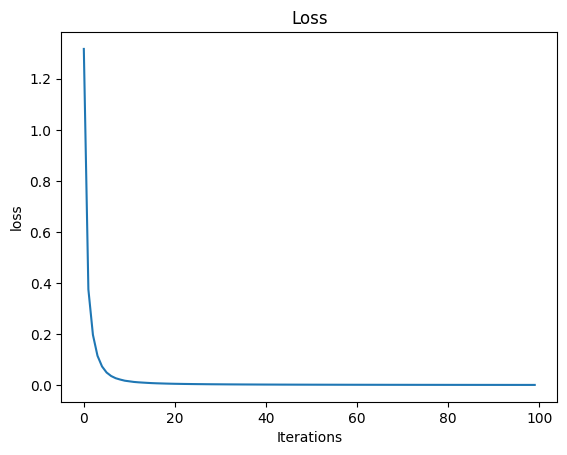

In [27]:
list_loss2 = opt2.SGD(datax,datay,size_batch,iteration)
plot_loss(iteration,list_loss2)

In [28]:
yhat = predict(opt2, decoded)
yhat_classes = np.argmax(yhat, axis=1)
testy_classes = np.argmax(testy, axis=1)
print("Taux de bonnes classifications : ", np.mean(yhat_classes == testy_classes))

Taux de bonnes classifications :  0.7294469357249627


## Matrice de confusion

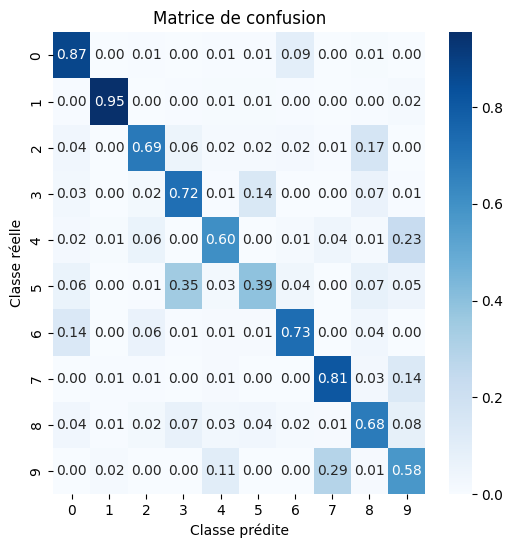

In [29]:
cm = confusion_matrix(testy_classes, yhat_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm/np.sum(cm, axis=1)[:, np.newaxis], annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')
plt.show()

# Ajout de bruit

## Données sans bruit

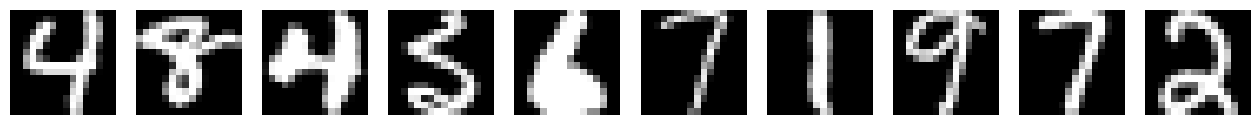

In [30]:
show_usps(testx, random_indices, nb_indices)

## Bruit gaussien

### Avec apprentissage sans bruit 

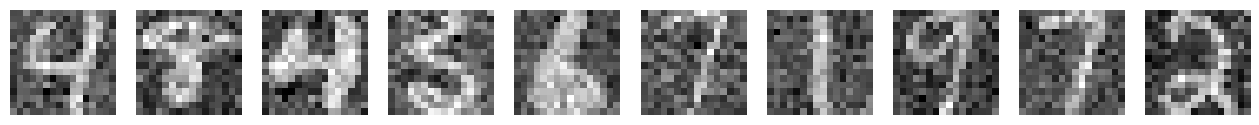

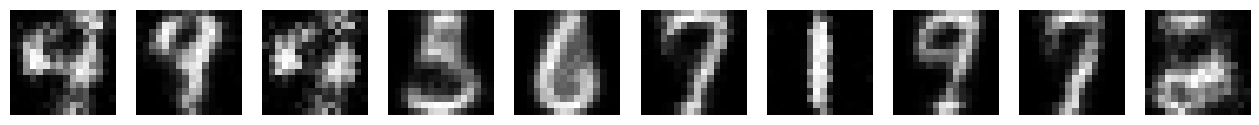

In [31]:
gaussian_testx = noisy_data(testx, 'gaussian', 0.75)
encoded_g, decoded_g = reconstruct(opt, gaussian_testx, len(encodeur))
show_usps(gaussian_testx, random_indices, nb_indices)
show_usps(decoded_g, random_indices, nb_indices)

In [32]:
yhat_gaussien = predict(opt2, gaussian_testx)
yhat_classes = np.argmax(yhat_gaussien, axis=1)
testy_classes = np.argmax(testy, axis=1)
print("Taux de bonnes classifications : ", np.mean(yhat_classes == testy_classes))

Taux de bonnes classifications :  0.7638266068759342


In [33]:
yhat_gaussien = predict(opt2, decoded_g)
yhat_classes = np.argmax(yhat_gaussien, axis=1)
testy_classes = np.argmax(testy, axis=1)
print("Taux de bonnes classifications : ", np.mean(yhat_classes == testy_classes))

Taux de bonnes classifications :  0.6806178375685102


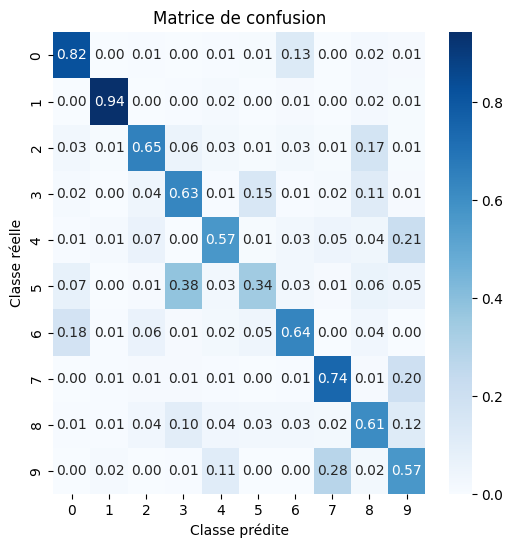

In [34]:
cm = confusion_matrix(testy_classes, yhat_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm/np.sum(cm, axis=1)[:, np.newaxis], annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')
plt.show()

### Apprentissage avec bruit

In [35]:
gaussian_datax = noisy_data(datax, 'gaussian', 0.75)

input = gaussian_datax.shape[1]
output = 10
iteration = 100
gradient_step = 1e-4
size_batch = 100

In [36]:
loss = BCE()
linear1 = Linear(input, 100)
linear2 = Linear(100, output)
linear3 = Linear(output, 100)
linear3._parameters = linear2._parameters.T
linear4 = Linear(100, input)
linear4._parameters = linear1._parameters.T
tanh = TanH()
sig = Sigmoide()

In [37]:
#AutoEncodeur
encodeur = [linear1,tanh,linear2,tanh]
decodeur = [linear3,tanh,linear4,sig]
autoEncodeur = AutoEncodeur(encodeur, decodeur)

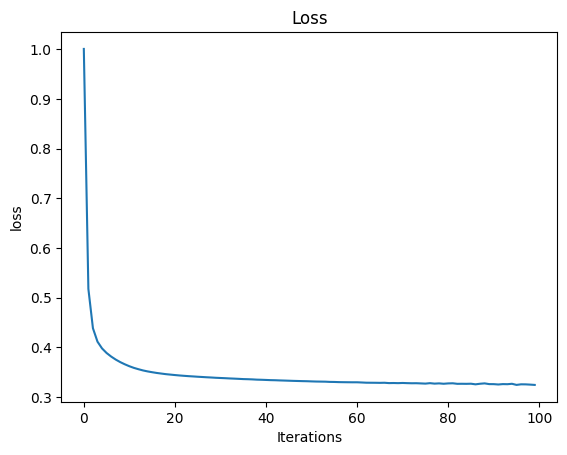

In [38]:
opt_gauss = Optim(autoEncodeur.modules, loss, eps=gradient_step)

list_loss = opt_gauss.SGD(gaussian_datax,datax,size_batch,iteration)
plot_loss(iteration,list_loss)

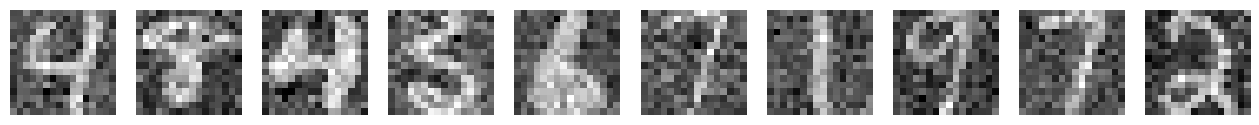

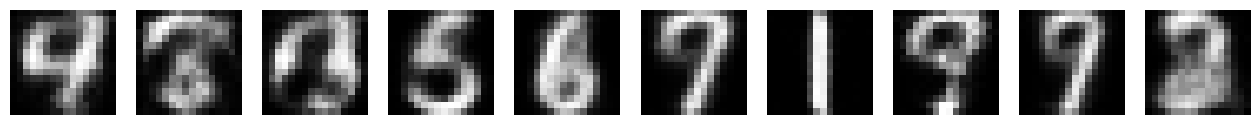

In [39]:
encoded_gauss, decoded_gauss = reconstruct(opt_gauss, gaussian_testx, len(encodeur))
show_usps(gaussian_testx, random_indices, nb_indices)
show_usps(decoded_gauss, random_indices, nb_indices)

In [40]:
yhat_gaussien = predict(opt2, gaussian_testx)
yhat_classes = np.argmax(yhat_gaussien, axis=1)
testy_classes = np.argmax(testy, axis=1)
print("Taux de bonnes classifications : ", np.mean(yhat_classes == testy_classes))

Taux de bonnes classifications :  0.7638266068759342


In [41]:
yhat_gaussien = predict(opt2, decoded_gauss)
yhat_classes = np.argmax(yhat_gaussien, axis=1)
testy_classes = np.argmax(testy, axis=1)
print("Taux de bonnes classifications : ", np.mean(yhat_classes == testy_classes))

Taux de bonnes classifications :  0.700548081714001


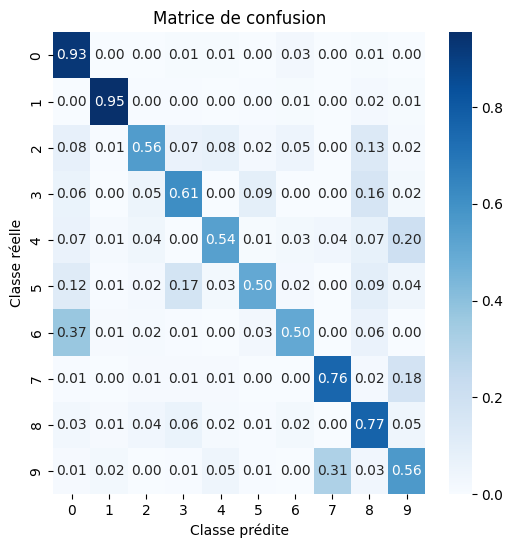

In [42]:
cm = confusion_matrix(testy_classes, yhat_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm/np.sum(cm, axis=1)[:, np.newaxis], annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')
plt.show()

## Bruit de Poisson

### Avec apprentissage sans bruit

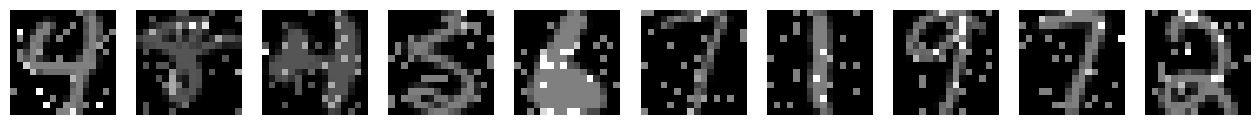

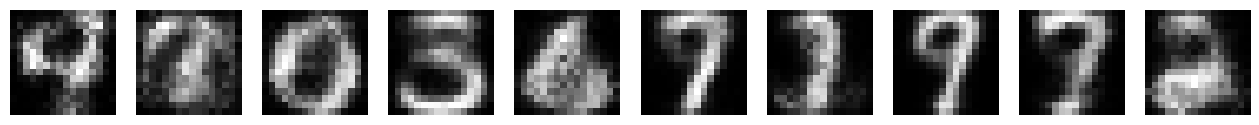

In [43]:
poisson_testx = noisy_data(testx, 'poisson', 0.5)
encoded_p, decoded_p = reconstruct(opt, poisson_testx, len(encodeur))
show_usps(poisson_testx, random_indices, nb_indices)
show_usps(decoded_p, random_indices, nb_indices)

In [44]:
yhat_poisson = predict(opt2, poisson_testx)
yhat_classes = np.argmax(yhat_poisson, axis=1)
testy_classes = np.argmax(testy, axis=1)
print("Taux de bonnes classifications : ", np.mean(yhat_classes == testy_classes))

Taux de bonnes classifications :  0.6611858495266567


In [45]:
yhat_poisson = predict(opt2, decoded_p)
yhat_classes = np.argmax(yhat_poisson, axis=1)
testy_classes = np.argmax(testy, axis=1)
print("Taux de bonnes classifications : ", np.mean(yhat_classes == testy_classes))

Taux de bonnes classifications :  0.5440956651718983


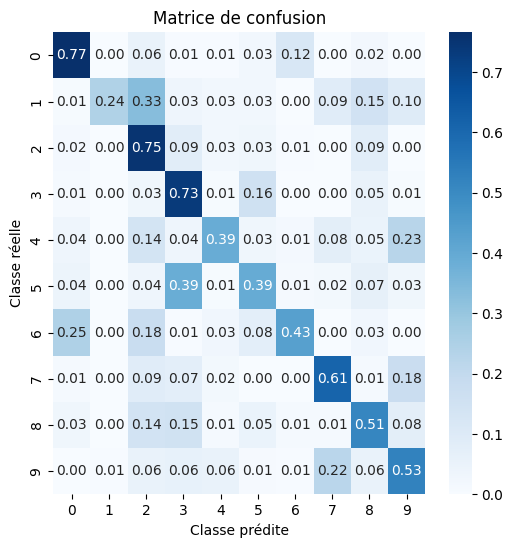

In [46]:
cm = confusion_matrix(testy_classes, yhat_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm/np.sum(cm, axis=1)[:, np.newaxis], annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')
plt.show()

### Apprentissage avec bruit

In [47]:
loss = BCE()
linear1 = Linear(input, 100)
linear2 = Linear(100, output)
linear3 = Linear(output, 100)
linear3._parameters = linear2._parameters.T
linear4 = Linear(100, input)
linear4._parameters = linear1._parameters.T
tanh = TanH()
sig = Sigmoide()

In [48]:
#AutoEncodeur
encodeur = [linear1,tanh,linear2,tanh]
decodeur = [linear3,tanh,linear4,sig]
autoEncodeur = AutoEncodeur(encodeur, decodeur)

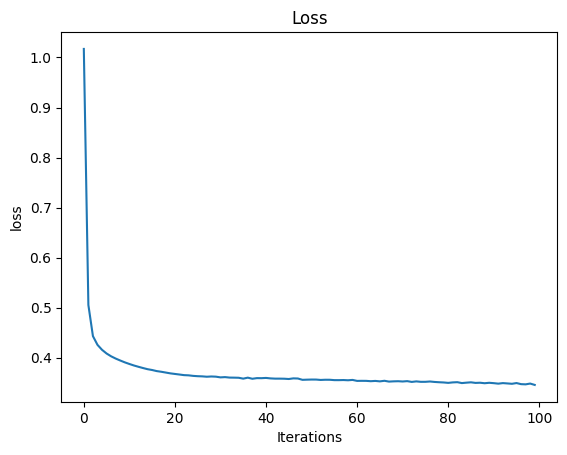

In [49]:
poisson_datax = noisy_data(datax, 'poisson', 0.5)

opt_poisson = Optim(autoEncodeur.modules, loss, eps=gradient_step)
list_loss = opt_poisson.SGD(poisson_datax,datax,size_batch,iteration)
plot_loss(iteration,list_loss)

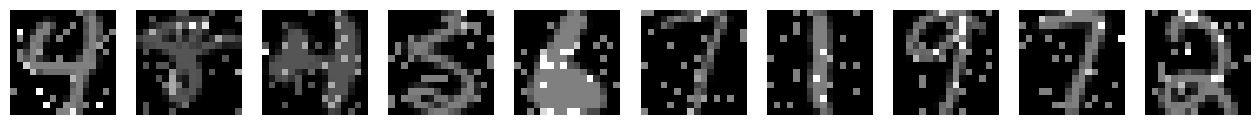

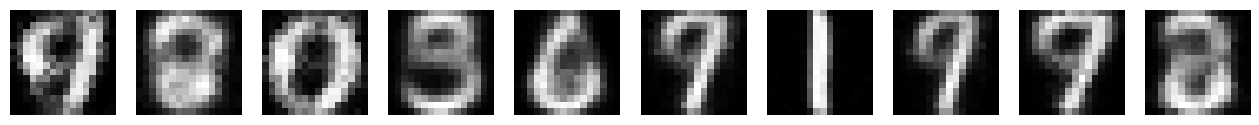

In [50]:
encoded_poisson, decoded_poisson = reconstruct(opt_poisson, poisson_testx, len(encodeur))
show_usps(poisson_testx, random_indices, nb_indices)
show_usps(decoded_poisson, random_indices, nb_indices)

In [51]:
yhat_poisson = predict(opt2, poisson_testx)
yhat_classes = np.argmax(yhat_poisson, axis=1)
testy_classes = np.argmax(testy, axis=1)
print("Taux de bonnes classifications : ", np.mean(yhat_classes == testy_classes))

Taux de bonnes classifications :  0.6611858495266567


In [52]:
yhat_poisson = predict(opt2, decoded_poisson)
yhat_classes = np.argmax(yhat_poisson, axis=1)
testy_classes = np.argmax(testy, axis=1)
print("Taux de bonnes classifications : ", np.mean(yhat_classes == testy_classes))

Taux de bonnes classifications :  0.5700049825610364


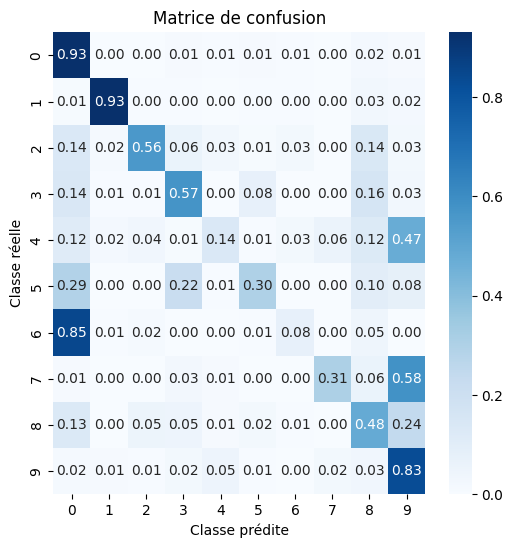

In [53]:
cm = confusion_matrix(testy_classes, yhat_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm/np.sum(cm, axis=1)[:, np.newaxis], annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')
plt.show()

## Bruit sel et poivre

### Avec apprentissage sans bruit

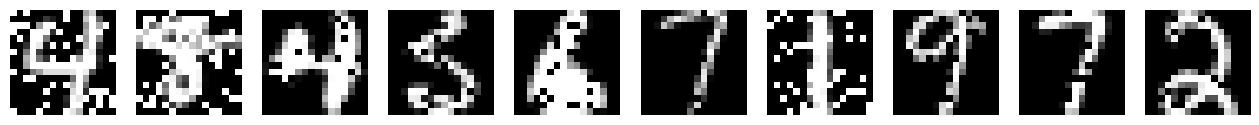

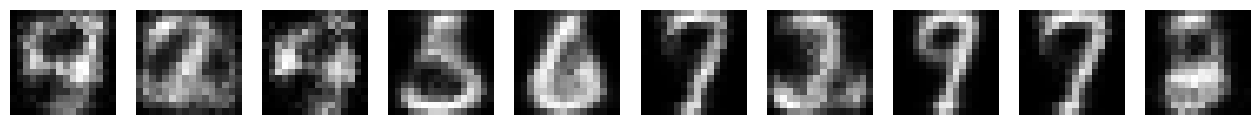

In [54]:
sap_testx = noisy_data(testx, 'salt_and_pepper', 0.2)
encoded_sp, decoded_sp = reconstruct(opt, sap_testx, len(encodeur))
show_usps(sap_testx, random_indices, nb_indices)
show_usps(decoded_sp, random_indices, nb_indices)

In [55]:
yhat_sap = predict(opt2, sap_testx)
yhat_classes = np.argmax(yhat_sap, axis=1)
testy_classes = np.argmax(testy, axis=1)
print("Taux de bonnes classifications : ", np.mean(yhat_classes == testy_classes))

Taux de bonnes classifications :  0.6567015445939213


In [56]:
yhat_sap = predict(opt2, decoded_sp)
yhat_classes = np.argmax(yhat_sap, axis=1)
testy_classes = np.argmax(testy, axis=1)
print("Taux de bonnes classifications : ", np.mean(yhat_classes == testy_classes))

Taux de bonnes classifications :  0.5296462381664175


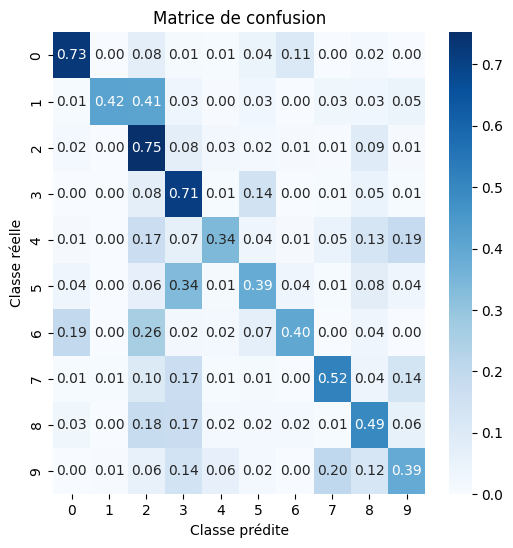

In [57]:
cm = confusion_matrix(testy_classes, yhat_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm/np.sum(cm, axis=1)[:, np.newaxis], annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')
plt.show()

### Apprentissage avec bruit

In [58]:
loss = BCE()
linear1 = Linear(input, 100)
linear2 = Linear(100, output)
linear3 = Linear(output, 100)
linear3._parameters = linear2._parameters.T
linear4 = Linear(100, input)
linear4._parameters = linear1._parameters.T
tanh = TanH()
sig = Sigmoide()

In [59]:
#AutoEncodeur
encodeur = [linear1,tanh,linear2,tanh]
decodeur = [linear3,tanh,linear4,sig]
autoEncodeur = AutoEncodeur(encodeur, decodeur)

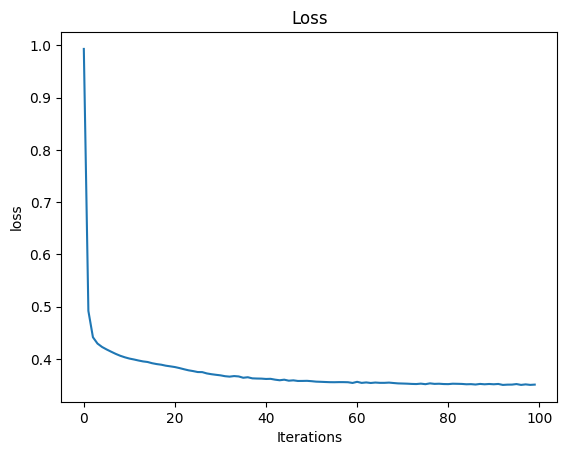

In [60]:
sap_datax = noisy_data(datax, 'salt_and_pepper', 0.2)

opt_sap = Optim(autoEncodeur.modules, loss, eps=gradient_step)

list_loss = opt_sap.SGD(sap_datax,datax,size_batch,iteration)
plot_loss(iteration,list_loss)

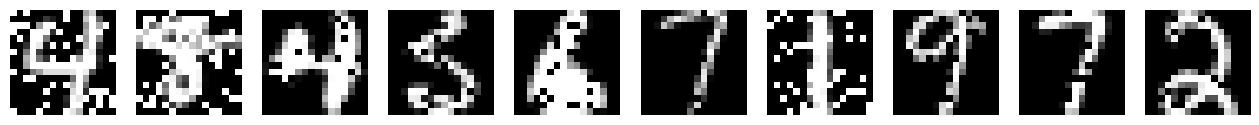

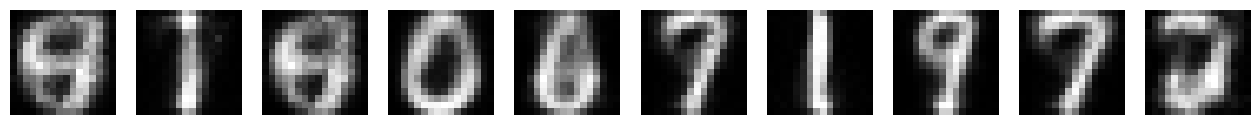

In [61]:
encoded_sap, decoded_sap = reconstruct(opt_sap, sap_testx, len(encodeur))
show_usps(sap_testx, random_indices, nb_indices)
show_usps(decoded_sap, random_indices, nb_indices)

In [62]:
yhat_sap = predict(opt2, sap_testx)
yhat_classes = np.argmax(yhat_sap, axis=1)
testy_classes = np.argmax(testy, axis=1)
print("Taux de bonnes classifications : ", np.mean(yhat_classes == testy_classes))

Taux de bonnes classifications :  0.6567015445939213


In [63]:
yhat_sap = predict(opt2, decoded_sap)
yhat_classes = np.argmax(yhat_sap, axis=1)
testy_classes = np.argmax(testy, axis=1)
print("Taux de bonnes classifications : ", np.mean(yhat_classes == testy_classes))

Taux de bonnes classifications :  0.5595416043846537


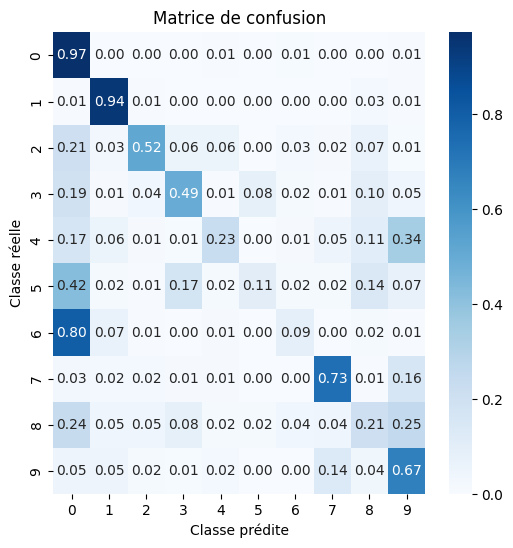

In [64]:
cm = confusion_matrix(testy_classes, yhat_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm/np.sum(cm, axis=1)[:, np.newaxis], annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de confusion")
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')
plt.show()

# TSNE

#### Données originales

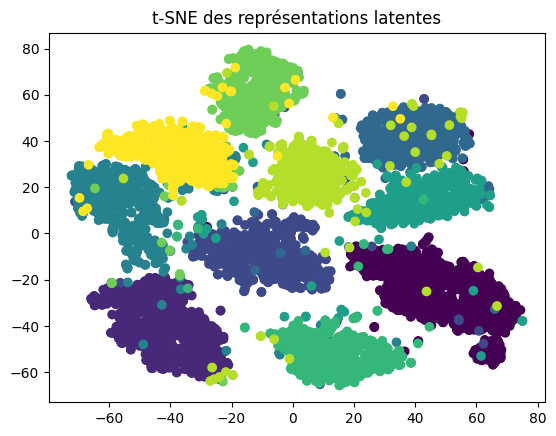

In [65]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)

latent_tsne = tsne.fit_transform(datax)
datay = np.argmax(datay, axis=1)

plt.scatter(latent_tsne[:,0], latent_tsne[:,1], c=datay)
plt.title('t-SNE des représentations latentes')
plt.show()

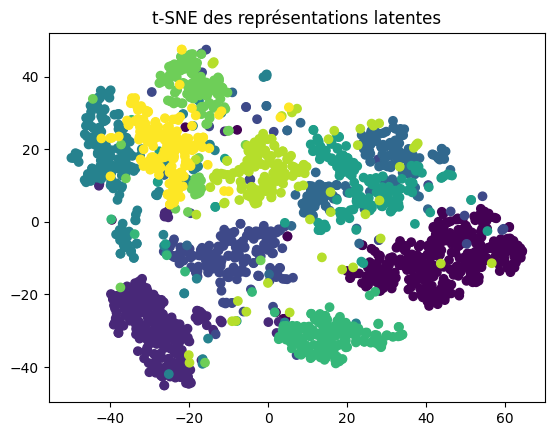

In [66]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)

latent_tsne = tsne.fit_transform(testx)

plt.scatter(latent_tsne[:,0], latent_tsne[:,1], c=testy_classes)
plt.title('t-SNE des représentations latentes')
plt.show()

### Compression en dimension 10

In [67]:
encoded_train, decoded_train = reconstruct(opt, datax, len(encodeur))

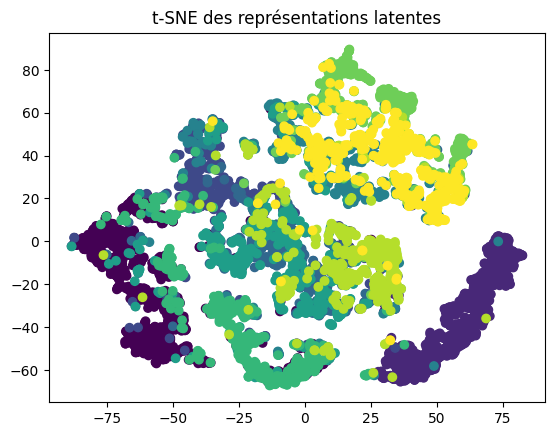

In [68]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)

latent_tsne = tsne.fit_transform(encoded_train)

plt.scatter(latent_tsne[:,0], latent_tsne[:,1], c=datay)
plt.title('t-SNE des représentations latentes')
plt.show()

In [69]:
encoded_test, decoded_test = reconstruct(opt, testx, len(encodeur))

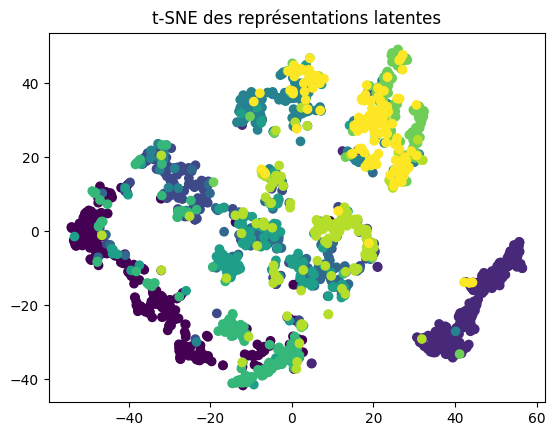

In [70]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)

latent_tsne = tsne.fit_transform(encoded_test)

plt.scatter(latent_tsne[:,0], latent_tsne[:,1], c=testy_classes)
plt.title('t-SNE des représentations latentes')
plt.show()